In [1]:
import os
from glob import glob
import nibabel as nib
from scipy.spatial.distance import dice
import numpy as np
import itk
import SimpleITK as sitk
import scipy.ndimage
import scipy
import matplotlib.pyplot as plt
import pandas as pd
from nilearn.reporting import make_glm_report
from nilearn.glm.second_level import SecondLevelModel
from nilearn import plotting
from nilearn.glm import threshold_stats_img

In [2]:
from nilearn.plotting import plot_design_matrix
mouses_filename = os.path.join('dataset2', 'Feminad', 'feminad.csv')
mouses_csv = pd.read_csv(mouses_filename)
male = mouses_csv['sex'] == 'M'
female = mouses_csv['sex'] == 'F'
age1 = mouses_csv['age'] == '2mois'
age2 = mouses_csv['age'] == '12mois'
m2 = male * age1
m12 = male * age2
f2 = female * age1
f12 = female * age2

33


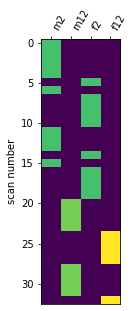

In [3]:
design_matrix = pd.DataFrame(np.vstack((m2, m12, f2, f12)).T,
                             columns=['m2', 'm12', 'f2', 'f12'])
ax = plot_design_matrix(design_matrix)
print(len(design_matrix))

output/Feminad/ANTS/Log10Jacobian_AffineDeformable/Log10JacobianAffineDeformable_Deformable_Norm_Resampled_N4_12_651701.nii.gz


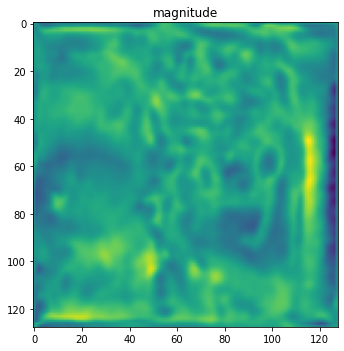

In [4]:
log_filenames = sorted(glob(os.path.join('output', 'Feminad', 'ANTS', 'Log10Jacobian_AffineDeformable', "*.nii.gz")))
for file in log_filenames:
    print(file)
    log10 = nib.load(file).get_fdata()    
    i = log10.shape[0]//2
    dat = (log10[i,:,:])
    plt.figure("Jacobian", (12, 6))
    plt.subplot(1, 2, 1)
    plt.title("magnitude")    
    plt.imshow(dat)
    plt.show()
    plt.show()
    break

In [5]:
#atlas_mri = os.path.join('dataset2', 'Atlas', 'Norm_Atlas_MRI_128.nii.gz')
#mask_img = nib.load(os.path.join('dataset2', 'Atlas', 'Atlas_Mask_128.nii.gz'))
atlas_mri = os.path.join('dataset2', 'Atlas', 'Deformable_Feminad_template0_sameaffine.nii.gz')
mask_img = nib.load(os.path.join('dataset2', 'Atlas', 'Deformable_Feminad_Mask_template0_sameaffine.nii.gz'))
second_level_model = SecondLevelModel(smoothing_fwhm=None, mask_img=mask_img)
second_level_model.fit(log_filenames,
                       design_matrix=design_matrix)

SecondLevelModel(mask_img=<nibabel.nifti1.Nifti1Image object at 0x7fdf0509e550>)

In [6]:
thresholds_dict = { 
                'fdr005': ('fdr', 0.05),
            }
contrasts_dict = {
    'age'    : [-1, 1, -1, 1],
}

In [7]:
for heights, values in thresholds_dict.items():
    report = make_glm_report(model=second_level_model,
                             contrasts=contrasts_dict,
                             bg_img=atlas_mri,
                             height_control=values[0],
                             alpha=values[1],
                             display_mode='z'
                             )
    report.save_as_html(os.path.join('output', 'Feminad', 'ANTS', 'Reports-AffineDeformable-NoSmoothing', 'report_affinedeformable_feminad_' + str(heights) + '.html'))

In [8]:
for k,v in contrasts_dict.items(): 
    z_map = second_level_model.compute_contrast(second_level_contrast=v, output_type='z_score')
    for heights, values in thresholds_dict.items():
        threshold_mask, threshold = threshold_stats_img(z_map, alpha=values[1], height_control=values[0])    
        nib.save(threshold_mask, os.path.join('output', 'Feminad', 'ANTS', 'Reports-AffineDeformable-NoSmoothing', str(k) + '_' + str(heights) + '.nii.gz'))